In [84]:
import gc
import sys
sys.path.append('../../../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
plt.ioff() # Turn off matplotlib interactive mode. Prevents  memory leakage.

In [3]:
# Load extracted raw signals
raw_signals = np.load('../../../data/STEAD/extracted_raw_signals_subsample_100000.npy')

# Load created waveform images
waveform_imgs = np.load('../../../data/STEAD/created_waveform_images_subsample_100000.npy')

# Load created spectrogram images
spectrogram_imgs = np.load('../../../data/STEAD/created_spectrogram_images_subsample_100000.npy')

# Load extracted raw signals
metadata = pd.read_feather('../../../data/STEAD/extracted_metadata_subsample_100000.feather')
metadata = metadata.reset_index()

In [4]:
subsample_indices = np.random.choice(len(spectrogram_imgs), size=2000)
subsample_imgs = spectrogram_imgs[subsample_indices]
subsample_metadata = metadata.iloc[subsample_indices]

In [5]:
subsample_metadata

,trace_name,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,...,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,chunk
61015,B918.PB_20150825065113_EV,PB,B918,EH,35.935700,-117.601700,1042.6,700.0,autopicker,0.88,...,None,None,0.37130,41.29,136.9,[28.89999962 31.5 34.29999924],[[1814.]],51:14.3,earthquake_local,4
80092,RSDD.HV_20180731120544_EV,HV,RSDD,EH,19.460170,-155.275330,1296.0,597.0,autopicker,0.92,...,None,None,0.06575,7.32,171.0,[25. 21.70000076 19.20000076],[[1635.]],05:45.8,earthquake_local,5
16965,KNW.AZ_20030224082702_EV,AZ,KNW,HH,33.714100,-116.711900,1507.0,900.0,manual,0.38,...,None,None,0.61220,67.95,349.2,[54.5 56.20000076 54.40000153],[[2792.]],2003-02-24 08:27:02.960000,earthquake_local,2
35827,GDXB.NC_20120708073612_EV,NC,GDXB,HH,38.807968,-122.795303,939.0,497.0,autopicker,0.84,...,NC,None,0.05405,6.04,103.0,[12.30000019 9.89999962 12.19999981],[[1454.]],2012-07-08 07:36:13.860000,earthquake_local,3
35656,GDXB.NC_20171204151902_EV,NC,GDXB,HH,38.807968,-122.795303,939.0,500.0,autopicker,0.93,...,None,None,0.01918,2.13,54.0,[35.09999847 31.29999924 33.79999924],[[1220.]],2017-12-04 15:19:03.350000,earthquake_local,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29284,MTP.PR_20140915003734_EV,PR,MTP,BH,18.097250,-65.552719,191.0,900.0,manual,0.50,...,None,None,1.56000,173.91,177.8,[ nan 19.70000076 20.29999924],[[5900.]],2014-09-15 00:37:35.270000,earthquake_local,2
65232,PRK.HL_20120327144450_EV,HL,PRK,HH,39.245650,26.264990,130.0,600.0,manual,0.50,...,None,None,0.40000,43.99,155.1,[41.29999924 36. 34.59999847],[[2491.]],44:51.6,earthquake_local,5
97299,ARK2.7F_20100729202254_NO,7F,ARK2,EH,35.334099,-92.298203,212.0,NaN,None,NaN,...,None,None,NaN,NaN,NaN,None,None,2010-07-29 20:22:54,noise,6
63707,SCZ.BK_20131124220635_EV,BK,SCZ,HH,36.598000,-121.403000,261.0,900.0,manual,0.00,...,None,None,0.24320,26.98,352.1,[24.10000038 16.70000076 16.60000038],[[1972.]],06:36.8,earthquake_local,5


In [6]:
labels = [1 if label=='earthquake_local' else 0 for label in subsample_metadata['trace_category']]

In [7]:
def cnn_image_preprocessing(image, image_size=(300,200)):
    image = tf.image.resize(image, image_size)  # Resize image
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

In [8]:
X_train, X_test, y_train, y_test = train_test_split(subsample_imgs, labels, random_state=0, test_size=0.25)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, test_size=0.25)

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [10]:
train_dataset = train_dataset.map(lambda x, y: (cnn_image_preprocessing(x), y))
val_dataset = val_dataset.map(lambda x, y: (cnn_image_preprocessing(x), y))
test_dataset = test_dataset.map(lambda x, y: (cnn_image_preprocessing(x), y))

In [11]:
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [16]:
# Callback to stop model training early if loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_classification_loss',    
    mode='min',
    patience=5,                # number of epochs to wait for improvement
    restore_best_weights=True, # restore the best weights once training stops
    verbose=1                 
)

# Callback to reduce learning rate if loss stops improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_classification_loss', 
    factor=0.1,                # the factor by which the learning rate will be reduced
    patience=2,                # number of epochs to wait for improvement
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss', 
    save_best_only=True        # save only the best model
)

callbacks = [
    early_stopping,
    reduce_lr,
    checkpoint
]

In [110]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')  # 10 output classes
])

In [111]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, epochs=5, callbacks=callbacks, validation_data=val_dataset)

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 740ms/step - accuracy: 0.5874 - loss: 0.6361 - val_accuracy: 0.8080 - val_loss: 0.4776 - learning_rate: 1.0000e-06
Epoch 2/5


/opt/miniconda3/envs/earthquake-detection/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_classification_loss` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/opt/miniconda3/envs/earthquake-detection/lib/python3.12/site-packages/keras/src/callbacks/callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_classification_loss` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 703ms/step - accuracy: 0.8143 - loss: 0.4487 - val_accuracy: 0.8080 - val_loss: 0.4193 - learning_rate: 1.0000e-06
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 686ms/step - accuracy: 0.7940 - loss: 0.4245 - val_accuracy: 0.8080 - val_loss: 0.3799 - learning_rate: 1.0000e-06
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 675ms/step - accuracy: 0.8144 - loss: 0.3728 - val_accuracy: 0.8080 - val_loss: 0.3533 - learning_rate: 1.0000e-06
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 677ms/step - accuracy: 0.8276 - loss: 0.3427 - val_accuracy: 0.8400 - val_loss: 0.3217 - learning_rate: 1.0000e-06


In [112]:
model.evaluate(test_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.8573 - loss: 0.3181


[0.33461400866508484, 0.8360000252723694]

In [113]:
def evaluate_classification_model(trained_model, history, test_dataset):
    # Parse test labels from test dataset
    test_labels = []
    for _, labels in test_dataset:
        test_labels.append(labels.numpy())
    test_labels = np.concatenate(test_labels)
    
    print('Evaluating model on test dataset')    
    print('Finding predicted classes and probabilities')
    predicted_classes = np.argmax(model.predict(test_dataset),axis=-1) # predict the class of each image
    predicted_probs = model.predict(test_dataset) # predict the probability of each image belonging to a class
    
    accuracy = accuracy_score(test_labels,predicted_classes)
    precision = precision_score(test_labels,predicted_classes)
    recall = recall_score(test_labels,predicted_classes)
    print(f'The accuracy of the model is {accuracy}, the precision is {precision}, and the recall is {recall}.')

    # create confusion matrix
    print('Building confusion matrix')
    cm = confusion_matrix(test_labels, predicted_classes) # compare target values to predicted values and show confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not earthquake','earthquake'])

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(test_labels, predicted_classes)
    roc_auc = auc(fpr, tpr)  

    # plot accuracy history, confusion matrix, roc curve
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5.5))
    ax1.plot(trained_model.history.history['accuracy'], color='xkcd:cranberry', label='Training accuracy')
    ax1.plot(trained_model.history.history['val_accuracy'], color='xkcd:dusty blue', label='Validation accuracy')
    ax1.grid(True, alpha=0.2, zorder=5)
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()    
    disp.plot(cmap='Blues', ax=ax2, values_format='')
    ax2.set_title('Classification CNN Results')
    ax3.plot(fpr, tpr, color='xkcd:cranberry', label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax3.plot([0, 1], [0, 1], color='lightgray', linestyle='--')  # Diagonal line (random classifier)
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax3.grid(True, alpha=0.2, zorder=5)
    plt.tight_layout()
    plt.show()
    

Evaluating model on test dataset
Finding predicted classes and probabilities
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step
The accuracy of the model is 0.836, the precision is 0.83125, and the recall is 0.9975.
Building confusion matrix


KeyError: 'accuracy'

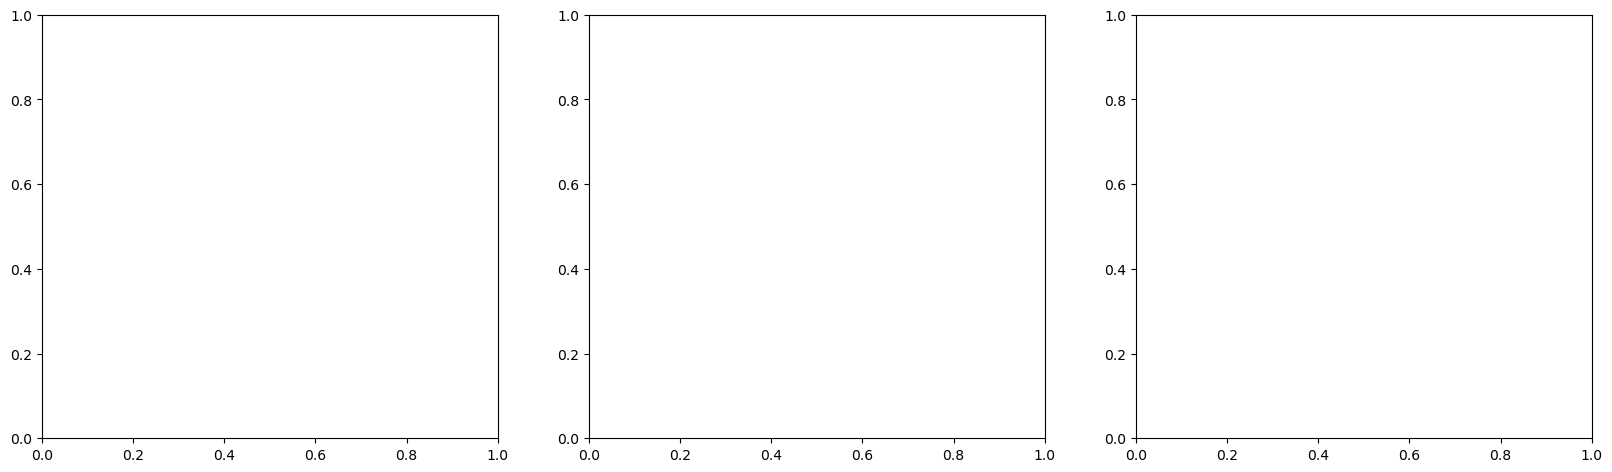

In [114]:
evaluate_classification_model(model, test_dataset)

In [116]:
model.history.history

{}

In [117]:
history.history

{'accuracy': [0.9066666960716248,
  0.9155555367469788,
  0.9324444532394409,
  0.9324444532394409,
  0.9440000057220459],
 'loss': [0.2734867036342621,
  0.2466326802968979,
  0.2290833294391632,
  0.21463479101657867,
  0.19958925247192383],
 'val_accuracy': [0.874666690826416,
  0.9066666960716248,
  0.9066666960716248,
  0.909333348274231,
  0.9413333535194397],
 'val_loss': [0.26691216230392456,
  0.23327772319316864,
  0.2173784226179123,
  0.20251847803592682,
  0.18526755273342133],
 'learning_rate': [9.999999974752427e-07,
  9.999999974752427e-07,
  9.999999974752427e-07,
  9.999999974752427e-07,
  9.999999974752427e-07]}